# Visualize Embeddings

## Libraries:

In [ ]:
%pip install plotly
%pip install emoji

In [ ]:
%pip install --upgrade emoji

In [1]:
from utils import *
from load_data import *
from process_data import *
from create_embeddings import *
from split_data import *
from create_model import *
from evaluate_model import *
from run_to_excel import *

import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, DistilBertTokenizer, BertModel, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup, RobertaTokenizer, RobertaModel, XLMRobertaModel, AutoTokenizer
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from sklearn.preprocessing import StandardScaler
import re
import string
from gensim.models.fasttext import FastText
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


## Run:

In [3]:
data = "../data/BBDD_SeAcabo.csv" # "data/BBDD_SeAcabo.csv" "AMI_IBEREVAL2018/es_AMI_TrainingSet_NEW.csv"
type_id = "analisis_general" # ["analisis_general", "contenido_negativo", "insultos"]
balance = "smote" # ["downsampling", "upsampling", "smote", "adasyn", "None"] # falta "smote", "adasyn" para analisis_general y contenido_negativo
embedding_name = "xlm-roberta-base" #["fasttext", "word2vec", "bow", "tfidf", "custom", "roberta", "beto", "bert-multi", "xlm-roberta-base"] // falta custom para ["analisis_general", "contenido_negativo", "insultos"]
embedding_size = 500 #[100, 500] 

# Cargamos datos
df = load_data(data)

# Preprocesado de datos
df, labels_names = process_data(df, type_id, balance)

# Embeddings
df, X, y = embedding_data(df, embedding_name, embedding_size)

# Text
text = df['full_text_processed']

c:\Users\jorge\Desktop\UNI\4-CUARTO\4-2-TFG\CODE\Gender-Bias\MachineLearning\process_data.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['view_count_scaled'] = scaler.fit_transform(df[['view_count']])
c:\Users\jorge\Desktop\UNI\4-CUARTO\4-2-TFG\CODE\Gender-Bias\MachineLearning\process_data.py:180: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mention_count'] = df['user_mentions'].apply(count_user_mentions)
c:\Users\jorge\Desktop\UNI\4-CUARTO\4-2-TFG\CODE\Gender-Bias\MachineLearning\process_dat


Soporte de etiquetas con nombres originales:
Comentario Positivo: 1234
Comentario Negativo: 367


In [4]:
# Text
# Después de procesar tu DataFrame (df), restablece los índices
df.reset_index(drop=True, inplace=True)

# Ahora extrae 'text'
text = df['full_text_processed']
print(text)

0                                     toda españa contigo
1       espero legue arope queremos transmitirte admir...
2                                                 no sola
3                                              dilo reina
4                                    dilo reina mano dura
                              ...                        
1596                                           paso atrás
1597                                                    z
1598                                  doblemente campeona
1599                              brava siempre campeonas
1600          después ver ¿te reafirmas mentira patéticas
Name: full_text_processed, Length: 1601, dtype: object


## Visualization:

In [6]:
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go

In [5]:
# Determinar el número de clases únicas
clases_unicas = np.unique(y)
colores = plt.cm.rainbow(np.linspace(0, 1, len(clases_unicas)))  # Generar colores
# Convertir colores RGB a hexadecimal
colores_hex = ["#"+"".join([f"{int(c*255):02x}" for c in color[:3]]) for color in colores]

### K-Means Clustering:

#### 2D:

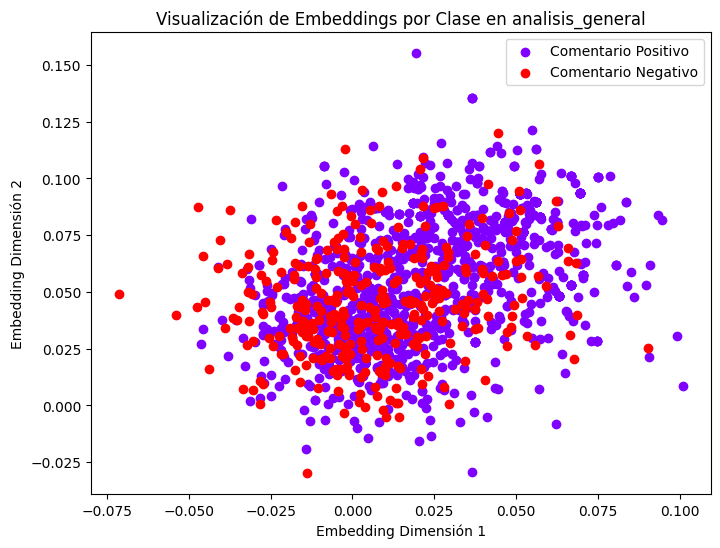

In [7]:
# Crear la figura para plotear
plt.figure(figsize=(8, 6))

# Plotear cada clase con un color diferente
for i, clase in enumerate(clases_unicas):
    indices = np.where(y == clase)
    plt.scatter(X[indices, 0], X[indices, 1], color=colores[i], label=labels_names[i])

# Añadir detalles al gráfico
plt.title(f'Visualización de Embeddings por Clase en {type_id}')
plt.xlabel('Embedding Dimensión 1')
plt.ylabel('Embedding Dimensión 2')
plt.legend()
plt.show()

#### 3D:

In [8]:
from sklearn.cluster import KMeans

# Ajustar K-means
kmeans = KMeans(n_clusters=len(clases_unicas), random_state=0).fit(X)
y_kmeans = kmeans.labels_

# Preparar el gráfico
data = []

for i, cluster in enumerate(clases_unicas):
    idx = y_kmeans == cluster
    text_labels = [text[j] for j in np.where(idx)[0]]
    trace = go.Scatter3d(
        x=X[idx, 0],
        y=X[idx, 1],
        z=X[idx, 2],
        mode='markers',
        name=labels_names[i],
        marker=dict(
            size=5,
            color=colores_hex[i]
        ),
        text=text_labels,  # Asignar etiquetas para mostrar en tooltips
        hoverinfo='text'  # Configurar el tooltip para mostrar solo el texto
    )
    data.append(trace)

layout = go.Layout(
    title='K-means Clustering en 3D',
    scene=dict(
        xaxis=dict(title='Dim 1'),
        yaxis=dict(title='Dim 2'),
        zaxis=dict(title='Dim 3'),
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

c:\Users\jorge\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


### PCA:

#### 2D:

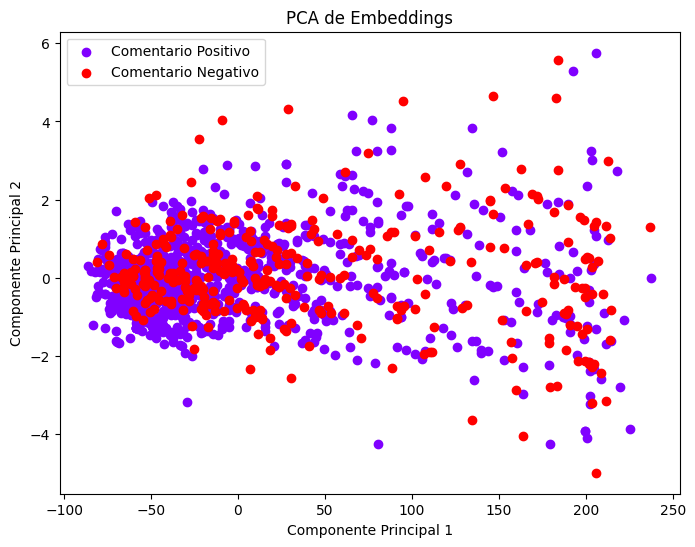

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
for i, clase in enumerate(clases_unicas):
    indices = np.where(y == clase)
    plt.scatter(X_pca[indices, 0], X_pca[indices, 1], label=labels_names[i], color=colores[i])
plt.title('PCA de Embeddings')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()


#### 3D:

In [10]:
import plotly.graph_objs as go
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 3 dimensiones
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# Preparar el gráfico
data = []

for i, clase in enumerate(clases_unicas):
    idx = y == clase
    text_labels = [text[j] for j in np.where(idx)[0]]
    trace = go.Scatter3d(
        x=X_pca[idx, 0],
        y=X_pca[idx, 1],
        z=X_pca[idx, 2],
        mode='markers',
        name=labels_names[i],
        marker=dict(
            size=5,
            color=colores_hex[i],
        ),
        text=text_labels,  # Asignar etiquetas para mostrar en tooltips
        hoverinfo='text'  # Configurar el tooltip para mostrar solo el texto
    )
    data.append(trace)

layout = go.Layout(
    title='PCA en 3D',
    scene=dict(
        xaxis=dict(title='PC 1'),
        yaxis=dict(title='PC 2'),
        zaxis=dict(title='PC 3'),
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()


### t-Distributed Stochastic Neighbor Embedding (t-SNE)

#### 2D:

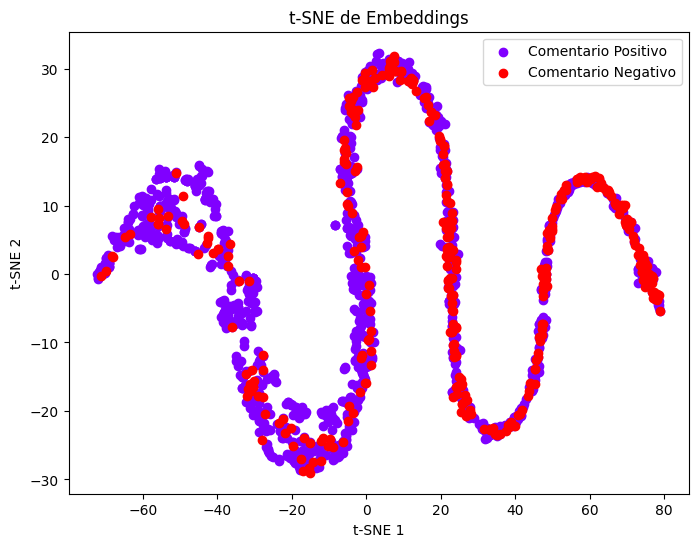

In [11]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(8, 6))
for i, clase in enumerate(clases_unicas):
    indices = np.where(y == clase)
    plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], label=labels_names[i],  color=colores[i])
plt.title('t-SNE de Embeddings')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.legend()
plt.show()


#### 3D:

In [12]:
from sklearn.manifold import TSNE

# Aplicar t-SNE para reducir a 3 dimensiones
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(X)

# Preparar el gráfico
data = []

for i, clase in enumerate(clases_unicas):
    idx = y == clase
    text_labels = [text[j] for j in np.where(idx)[0]]
    trace = go.Scatter3d(
        x=X_tsne[idx, 0],
        y=X_tsne[idx, 1],
        z=X_tsne[idx, 2],
        mode='markers',
        name=labels_names[i],
        marker=dict(
            size=5,
            color=colores_hex[i],
        ),
        text=text_labels,  # Asignar etiquetas para mostrar en tooltips
        hoverinfo='text'  # Configurar el tooltip para mostrar solo el texto
    )
    data.append(trace)

layout = go.Layout(
    title='t-SNE en 3D',
    scene=dict(
        xaxis=dict(title='t-SNE 1'),
        yaxis=dict(title='t-SNE 2'),
        zaxis=dict(title='t-SNE 3'),
    )
)

fig = go.Figure(data=data, layout=layout)
fig.show()

### Índice Davies-Bouldin

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

# Ajustar K-means a los datos
kmeans = KMeans(n_clusters=len(clases_unicas), random_state=0).fit(X)
y_kmeans = kmeans.labels_

# Calcular el índice Davies-Bouldin
db_index = davies_bouldin_score(X, y_kmeans)
print(f"Índice Davies-Bouldin: {db_index}") # cuanto más bajo mejor


c:\Users\jorge\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Índice Davies-Bouldin: 0.42871287071239733


### Silhoutte Score:

In [14]:
from sklearn.metrics import silhouette_score

# Asumiendo que X son tus embeddings y y son las etiquetas de clase
score = silhouette_score(X, y)
print(f"Coeficiente de Silueta para {type_id}: {score}") # cuanto más cerca de uno mejor

Coeficiente de Silueta para analisis_general: 0.20341080708545958
